In [17]:
import logging

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.stats import norm

from Preprocessing import Preprocessing
from FeatureEngineering import FeatureEngineering
from Calendar import RussianBusinessCalendar

from FeatureSelection import FeatureSelector
from ChangePointDetection import ChangePointDetector

In [18]:
date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")

df = pd.read_excel('data/Project 2_2023.xlsx', sheet_name='Data', parse_dates=['Date'], date_parser=date_parser)
df = df.set_index('Date')
df.index.name = 'Date'
df['Balance_correct'] = df['Income'] - df['Outcome']

In [19]:
prep = Preprocessing()
series = prep.preprocess(df['Balance_correct'])

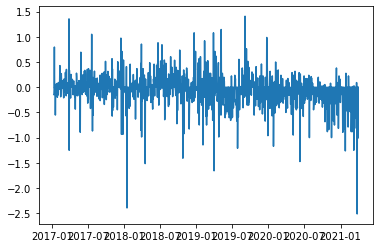

In [20]:
plt.plot(series)

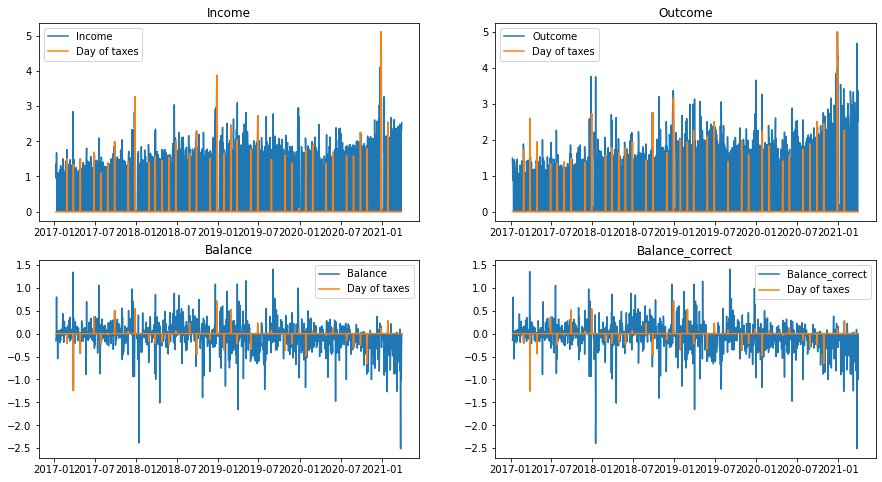

In [21]:
df['Taxes'] = list(pd.Series(df.index).apply(lambda x: 1 if x.day == 28 else 0))

fig, axs = plt.subplots(2, 2, figsize=(15, 8))
for i, column in enumerate(df.columns[:4]):
    axs[i//2][i%2].plot(df[column], label=column)
    axs[i//2][i%2].plot(df[column]*df['Taxes'], label='Day of taxes')
    axs[i//2][i%2].set_title(column)
    axs[i//2][i%2].legend()

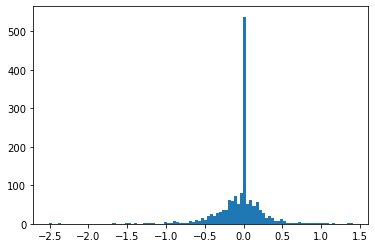

In [22]:
plt.hist(df['Balance_correct'], bins=100)
print()

In [148]:
series.std()

0.29204470271043675

# Поиск аномалий

# FE

In [23]:
features = pd.read_csv('data/FE.csv', sep=';', index_col=0)
target = series.shift(-1)[:-1]
income = df['Income']
outcome = df['Outcome']

# FS

In [24]:
# from mlxtend.feature_selection import SequentialFeatureSelector
# from sklearn.feature_selection import VarianceThreshold, SelectFromModel
# from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
# from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
# from pyitlib import discrete_random_variable as drv
# from tqdm.notebook import tqdm

# class FeatureSelection():
#     def __init__(self, features, target, scoring='neg_mean_absolute_error', k_features=50):
#         self.features = features
#         self.target = target
#         self.k_features = k_features
#         self.scoring = scoring
#         self.wrapper_features = None
#         self.correlation_features = None
#         self.filter_features = None
#         self.embedded_lasso_features = None
#         self.embedded_ridge_features = None
#         self.embedded_elastic_features = None
        
#     # Оберточный метод – SequentialFeatureSelector
#     def wrapper_method(self):
#         feature_selector = SequentialFeatureSelector(Lasso(),
#            k_features=self.k_features,
#            forward=True,
#            verbose=2,
#            scoring=self.scoring,
#            cv=4)
#         features = feature_selector.fit(np.array(self.features.fillna(0)), self.target)
#         self.wrapper_features = self.features[self.features.columns[list(features.k_feature_idx_)]]
#         return self.wrapper_features
    
#     # Фильтр – корреляция
#     def correlation_method(self):
#         corr = dict()
#         for i in self.features.columns:
#             corr[i] = [self.target.corr(self.features[i])]
#         self.correlation_features = \
#                 self.features[pd.DataFrame(corr).T.sort_values(0, 
#                                                                key=abs, 
#                                                                ascending=False).iloc[:self.k_features].index]
#         return self.correlation_features

#     # Фильтр – Mutual Information
#     def filtered_method(self):
#         # Remove quasi-constant features
#         filter_ = VarianceThreshold(threshold=0.01)
#         filter_.fit(self.features)
#         self.filter_features = filter_.transform(self.features)
#         self.filter_features =  pd.DataFrame(self.filter_features, index=self.features.index,
#                                             columns=self.features.columns[filter_.get_support()])
        
#         # mutual info conditional
#         chosen_columns = dict()
#         chosen_columns['const'] = pd.Series([1] * len(self.target), index=self.features.index)
#         for i in tqdm(range(self.k_features)):
#             mi_cumsum = dict()
#             for X in self.filter_features.columns:
#                 mi_cumsum[X] = 0
#                 for Z in chosen_columns:
#                     mi_cumsum[X] += drv.information_mutual_conditional(self.features[X].values.flatten(), 
#                                                self.target.values, 
#                                                chosen_columns[Z].values.flatten())
#             chosen_feature = sorted(mi_cumsum.items(), key=lambda x:x[1])[-1][0]
#             chosen_columns[chosen_feature] = self.features[chosen_feature]
#             self.filter_features = self.filter_features.drop(columns=chosen_feature)

#         self.filter_features = pd.DataFrame(chosen_columns).drop(columns='const')
#         return self.filter_features
    
#     # Встроенные – Lasso, Ridge, Elastic Net
#     def embedded_method(self):
#         sel_lasso = SelectFromModel(Lasso(alpha=0.001, random_state=10))
#         sel_lasso.fit(self.features, self.target)
#         self.embedded_lasso_features = self.features[self.features.columns[sel_lasso.get_support()]]
        
#         sel_ridge = SelectFromModel(Ridge(alpha=0.001, random_state=10))
#         sel_ridge.fit(self.features, self.target)
#         self.embedded_ridge_features = self.features[self.features.columns[sel_ridge.get_support()]]
        
#         sel_elastic = SelectFromModel(ElasticNet(alpha=0.001, random_state=10))
#         sel_elastic.fit(self.features, self.target)
#         self.embedded_elastic_features = self.features[self.features.columns[sel_elastic.get_support()]]
        
#         return self.embedded_lasso_features, self.embedded_ridge_features, self.embedded_elastic_features

In [25]:
# fs = FeatureSubsetGenerator(features, target, 'neg_mean_absolute_error', 10)
# # res = fs.wrapper_method()
# res_cor = fs.correlation_method()
# # res_filter = fs.filtered_method()
# res_emb2 = fs.embedded_method_ridge()

In [26]:
# fs = FeatureSelector()
# features_best = fs.select_features(features, target)
# features_best

In [27]:
features_best = np.array(['const', 'std_12', 'std_5', 'std_10', 'std_13', 'std_9', 'std_6',
       'std_11', 'std_4', 'mean_12', 'mean_13', 'std_3', 'mean_11',
       'mean_9', 'mean_10', 'mean_6', 'std_8', 'mean_5', 'mean_4',
       'std_14', 'diffs_13', 'diffs_6', 'diffs_3', 'mean_3', 'diffs_5',
       'mean_8', 'diffs_4', 'diffs_9', 'std_7', 'diffs_12', 'diffs_10',
       'mean_14', 'diffs_11', 'diffs_2', 'day_of_year', 'mean_7', 'lag_6',
       'lag_13', 'diffs_8', 'median_2', 'lag_5', 'diffs_1', 'min_6',
       'lag_12', 'median_4', 'std_2', 'lag_3', 'diffs_14', 'min_9',
       'lag_9', 'lag_4'])

In [28]:
# # based on
# # https://www.sarem-seitz.com/probabilistic-cusum-for-change-point-detection/

# import torch
# import numpy as np
# import pandas as pd
# from datetime import datetime, timedelta
# import matplotlib.pyplot as plt

# from typing import Tuple
# from Calendar import RussianBusinessCalendar


# class CusumMeanDetector():
#     def __init__(self, t_warmup = 30, p_limit = 0.1) -> None:
#         self._t_warmup = t_warmup
#         self._p_limit = p_limit
        
#         self._reset()

#     def predict_next(self, y: torch.tensor) -> Tuple[float,bool]:
#         self._update_data(y)

#         if self.current_t == self._t_warmup:
#             self._init_params()
        
#         if self.current_t >= self._t_warmup:
#             prob, is_changepoint = self._check_for_changepoint()
#             if is_changepoint:
#                 self._reset()

#             return (1-prob), is_changepoint
        
#         else:
#             return 0, False
            
#     def _reset(self) -> None:
#         self.current_t = torch.zeros(1)
                
#         self.current_obs = []
        
#         self.current_mean = None
#         self.current_std = None
    
#     def _update_data(self, y: torch.tensor) -> None:
#         self.current_t += 1
#         self.current_obs.append(y.reshape(1))

        
#     def _init_params(self) -> None:
#         self.current_mean = torch.mean(torch.concat(self.current_obs))
#         self.current_std = torch.std(torch.concat(self.current_obs))
             
#     def _check_for_changepoint(self) -> Tuple[float,bool]:
#         standardized_sum = torch.sum(torch.concat(self.current_obs) - self.current_mean)/(self.current_std * self.current_t**0.5)
#         prob = float(self._get_prob(standardized_sum).detach().numpy())
        
#         return prob, prob < self._p_limit
    
#     def _get_prob(self, y: torch.tensor) -> bool:
#         p = torch.distributions.normal.Normal(0,1).cdf(torch.abs(y))
#         prob = 2*(1 - p)
        
#         return prob
    
# class ChangePointDetector():
#     def __init__(self):
#         self.initial_dates = None
#         self.date_no_holidays = None
#         self.series = None
#         self.series_no_holidays = None
#         self.detector = None
#         self.outs = None
#         self.cps = None
#         self.cps_dates = None
#         self.probs = None
        
#         calendar = RussianBusinessCalendar()
#         self.holidays = [date.date() for date in calendar.get_holidays()]

        
#     def delete_holidays(self, series):
#         delete_days = np.where(series.index.isin(self.holidays))[0]
#         no_holidays = series.drop(series.index[delete_days])
#         weekends = pd.Series(no_holidays.index).apply(lambda x: True if x.dayofweek in [5,6] else False)
        
#         self.series_no_holidays = no_holidays.drop(no_holidays.index[weekends])
#         self.date_no_holidays = pd.Series(self.series_no_holidays.index)
#         self.series_no_holidays = torch.tensor(self.series_no_holidays.values)
    
#     def detect_changepoint(self, series):
#         self.initial_dates = pd.Series(series.index)
#         self.series = torch.tensor(series.values)
#         self.delete_holidays(series)
        
#         self.detector = CusumMeanDetector()
#         self.outs = [self.detector.predict_next(
#             self.series_no_holidays[i]) for i in range(len(self.series_no_holidays))]
        
#         self.cps = np.where(list(map(lambda x: x[1], self.outs)))[0]
#         self.probs = np.array(list(map(lambda x: x[0], self.outs)))
        
#         self.cps_dates = self.date_no_holidays[self.cps]
#         self.cps = np.where(self.initial_dates.isin(self.cps_dates))[0]
#         return max(self.cps_dates)
    
#     def plot_changepoints(self):
#         X, Y = np.meshgrid(np.arange(len(self.series)),np.linspace(min(self.series), max(self.series)))

#         plt.figure(figsize=(18,9))
#         plt.plot(np.arange(len(self.series)),self.series.detach().numpy(),lw=0.75,label="Data",color="blue")

#         plt.axvline(self.cps[0], color="red", linestyle="dashed",label="Detected changepoints",lw=2)
#         [plt.axvline(cp, color="red", linestyle="dashed",lw=2) for cp in self.cps[1:]]

#         plt.legend()
        
#     def return_minimum_period(self):
#         to_count = pd.Series([self.initial_dates[0]-timedelta(days=1), *self.cps_dates])
#         periods = []
#         for i in range(len(to_count) - 1):
#             periods.append(to_count.iloc[i + 1] - to_count.iloc[i])
#         return min(periods).days

56

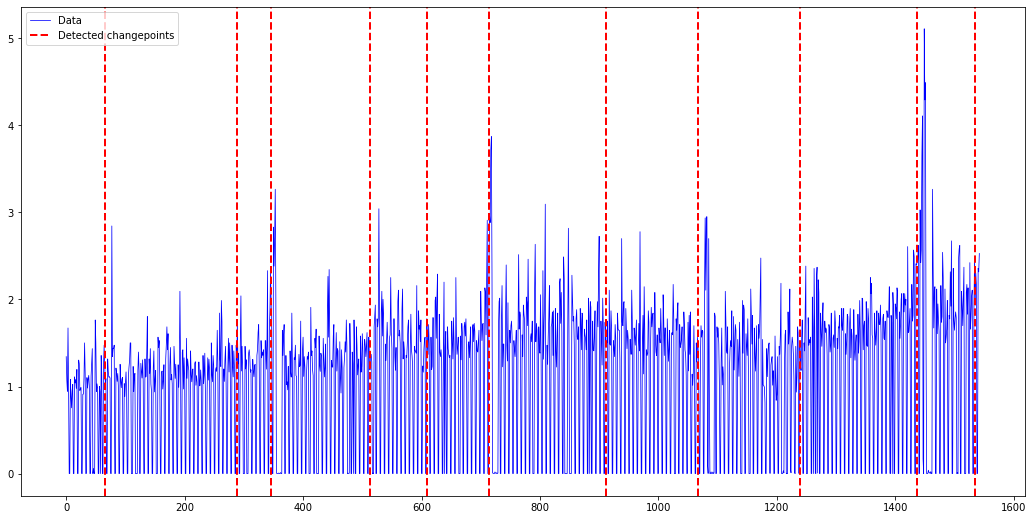

In [29]:
cpd = ChangePointDetector()
dates = cpd.detect_changepoint(income)
cpd.plot_changepoints()
cpd.return_minimum_period()

In [30]:
dates

Timestamp('2021-03-24 00:00:00')

In [31]:
income[-10:]

Date
2021-03-22    1.961875
2021-03-23    2.488553
2021-03-24    1.935541
2021-03-25    2.304215
2021-03-26    2.172546
2021-03-27    0.000000
2021-03-28    0.000000
2021-03-29    2.356883
2021-03-30    2.317382
2021-03-31    2.528054
Name: Income, dtype: float64

In [32]:
(to_count.iloc[i + 1] - to_count.iloc[i]).days

NameError: name 'to_count' is not defined

TypeError: Value after * must be an iterable, not Timestamp

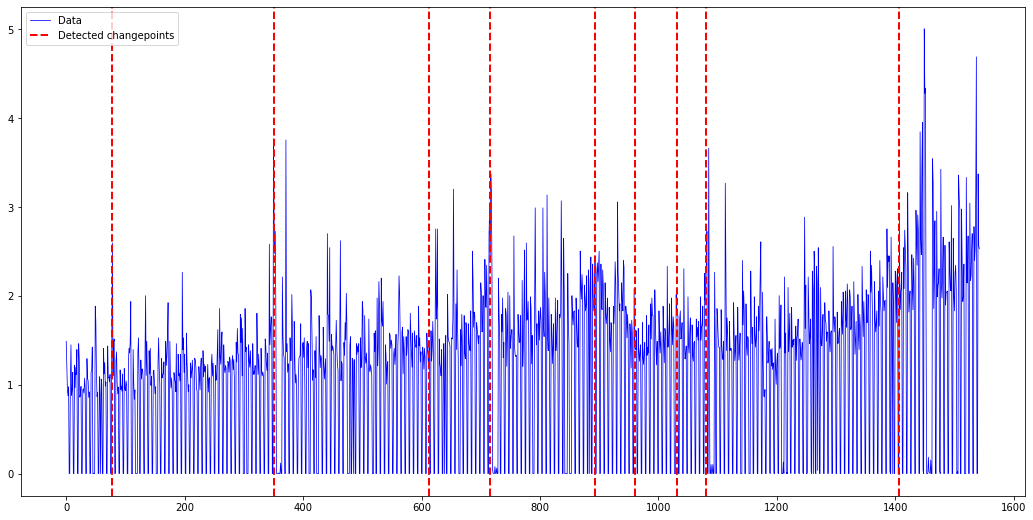

In [33]:
cpd = ChangePointDetector()
dates = cpd.detect_changepoint(outcome)
cpd.plot_changepoints()

to_count = pd.Series([outcome.index[0]-timedelta(days=1), *dates])
for i in range(len(to_count) - 1):
    print(to_count.iloc[i + 1] - to_count.iloc[i])

In [ ]:
cps

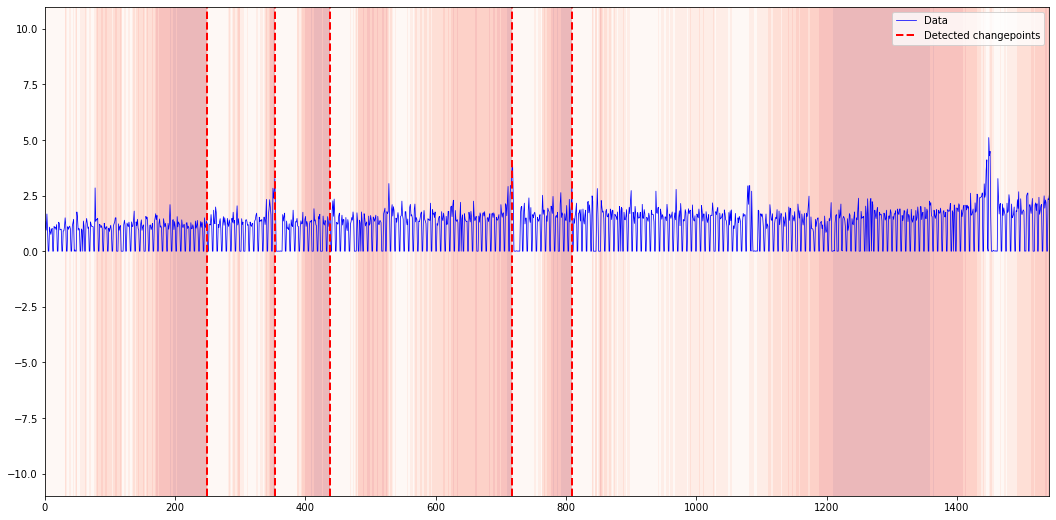

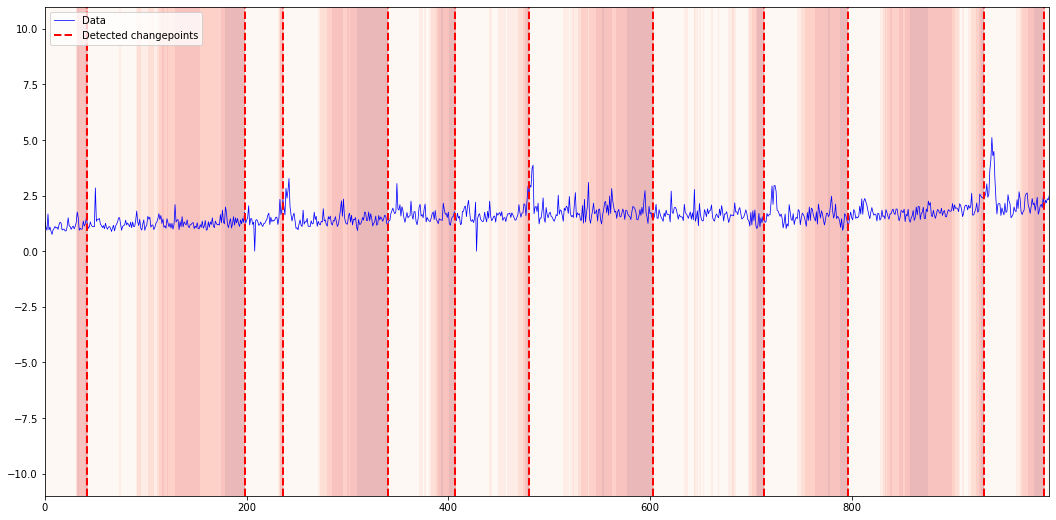

In [115]:
plot_changepoints(income)
plot_changepoints(income_no_holidays)

# Model select

In [36]:
X = features
y = target

In [95]:
np.logspace(-5, 1, 19)

array([1.00000000e-05, 2.15443469e-05, 4.64158883e-05, 1.00000000e-04,
       2.15443469e-04, 4.64158883e-04, 1.00000000e-03, 2.15443469e-03,
       4.64158883e-03, 1.00000000e-02, 2.15443469e-02, 4.64158883e-02,
       1.00000000e-01, 2.15443469e-01, 4.64158883e-01, 1.00000000e+00,
       2.15443469e+00, 4.64158883e+00, 1.00000000e+01])

In [103]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV

model = ElasticNet()
parameters = {"alpha":np.logspace(-5, 2, 8),
              "l1_ratio":np.linspace(0, 1, 11),
              "fit_intercept":[False, True]}
grid_GBR = GridSearchCV(estimator=model, param_grid = parameters, cv = 5, n_jobs=-1)
grid_GBR.fit(X, y)
hyperparameters = grid_GBR.best_params_
hyperparameters

/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.41813696181213, tolerance: 0.00970031986358867
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.904815365047995, tolerance: 0.012082463550817515
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.51039441597768, tolerance: 0.01078981191133377
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/li

/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.542290705412434, tolerance: 0.00970031986358867
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.02790756394401, tolerance: 0.012082463550817515
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.088907570059966, tolerance: 0.010231909937070531
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/

/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.11830890191437, tolerance: 0.009950250737866618
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.055933658106035, tolerance: 0.009950250737866618
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.54292596480781, tolerance: 0.010279120284931142
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/

/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.883273849998304, tolerance: 0.01078981191133377
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.24654667685111, tolerance: 0.010977762065842802
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.16465880529494, tolerance: 0.012082463550817515
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/l

/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.586697049137335, tolerance: 0.01078981191133377
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.4008158526289, tolerance: 0.011265534121422218
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.24683134605229, tolerance: 0.00970031986358867
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/lin

/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.226111347593076, tolerance: 0.009950250737866618
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.930461750504115, tolerance: 0.010977762065842802
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.593854284213315, tolerance: 0.010279120284931142
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklear

/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.65387870352517, tolerance: 0.011265534121422218
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.52515311834154, tolerance: 0.01078981191133377
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.26412735545955, tolerance: 0.00970031986358867
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/lin

/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.425709396506555, tolerance: 0.010231909937070531
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.12364821024129, tolerance: 0.011265534121422218
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.63131217655609, tolerance: 0.010231909937070531
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/

/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.77062088723175, tolerance: 0.00965510568818012
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.539255662587344, tolerance: 0.010279120284931142
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.132764220426722, tolerance: 0.011572890565183779
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/li

/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5922808124461341, tolerance: 0.009950250737866618
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24474106911996785, tolerance: 0.00965510568818012
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.643419957026715, tolerance: 0.012082463550817515
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklear

/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1427534796768413, tolerance: 0.011265534121422218
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.472835334634105, tolerance: 0.01078981191133377
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16634257426758836, tolerance: 0.010279120284931142
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklear

/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53.9396631201605, tolerance: 0.012082463550817515
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.49385132240064, tolerance: 0.009950250737866618
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.5449870578171, tolerance: 0.010977762065842802
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/lin

/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.07070036811313, tolerance: 0.00970031986358867
  model = cd_fast.enet_coordinate_descent(
/Users/elina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.06598306556887, tolerance: 0.00965510568818012
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.001, 'fit_intercept': True, 'l1_ratio': 0.2222222222222222}

In [51]:
hyperparameters

{'fit_intercept': True}

In [109]:
X

,Balance,day_of_week,holidays,weekdays,taxes_day,month,quarter,year,weekofyear,day_of_year,...,Balance__abs_energy,"Balance__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","Balance__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)",Balance__value_count__value_0,Balance__benford_correlation,Balance__root_mean_square,Balance__range_count__max_0__min_-1000000000000.0,"Balance__fft_coefficient__attr_""angle""__coeff_0",Balance__range_count__max_1000000000000.0__min_0,"Balance__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)"
2017-01-09,-0.144836,0.000000,0.0,0.0,0.0,1.0,1.0,2017.0,2.0,9.0,...,0.020978,-0.056179,-0.028090,0.0,0.864123,0.144836,1.0,180.0,0.0,-0.088827
2017-01-10,-0.125572,0.143837,0.0,0.0,0.0,1.0,1.0,2017.0,2.0,10.0,...,0.015768,-0.048707,-0.024353,0.0,0.864123,0.125572,1.0,180.0,0.0,-0.077012
2017-01-11,0.007767,0.293751,0.0,0.0,0.0,1.0,1.0,2017.0,2.0,11.0,...,0.000060,0.003013,0.001506,0.0,-0.241690,0.007767,0.0,0.0,1.0,0.004763
2017-01-12,0.796823,0.456893,0.0,0.0,0.0,1.0,1.0,2017.0,2.0,12.0,...,0.634927,0.309071,0.154536,0.0,-0.241690,0.796823,0.0,0.0,1.0,0.488685
2017-01-13,-0.019721,0.642986,0.0,0.0,0.0,1.0,1.0,2017.0,2.0,13.0,...,0.000389,-0.007649,-0.003825,0.0,0.864123,0.019721,1.0,180.0,0.0,-0.012095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-26,-2.514887,0.642986,0.0,0.0,0.0,3.0,1.0,2021.0,12.0,85.0,...,6.324655,-0.975473,-0.487737,0.0,0.295657,2.514887,1.0,180.0,0.0,-1.542358
2021-03-27,0.000000,0.867008,0.0,0.0,0.0,3.0,1.0,2021.0,12.0,86.0,...,0.000000,0.000000,0.000000,1.0,0.295657,0.000000,0.0,0.0,1.0,0.000000
2021-03-28,0.000000,1.154866,0.0,1.0,1.0,3.0,1.0,2021.0,12.0,87.0,...,0.000000,0.000000,0.000000,1.0,0.295657,0.000000,0.0,0.0,1.0,0.000000
2021-03-29,-1.013855,0.000000,0.0,0.0,0.0,3.0,1.0,2021.0,13.0,88.0,...,1.027902,-0.393254,-0.196627,0.0,0.864123,1.013855,1.0,180.0,0.0,-0.621788


In [112]:
from sklearn import svm
model = svm.SVR()
parameters = {"kernel": ["linear", "poly", "rbf", "sigmoid"],
              "degree":np.linspace(1, 5, 5)}
grid_GBR = GridSearchCV(estimator=model, param_grid = parameters, cv = 5, n_jobs=-1)
grid_GBR.fit(X, y)
hyperparameters = grid_GBR.best_params_
hyperparameters

{'degree': 3.0, 'kernel': 'poly'}

In [126]:
np.linspace(1, 5, 5)

array([1., 2., 3., 4., 5.])

In [124]:
from sklearn.preprocessing import StandardScaler
pipeline = StandardScaler()
pipeline.fit(X)
pipeline.fit_transform(X)

array([[-0.32864128, -1.34032148, -0.30975608, ...,  1.18875798,
        -1.18875798, -0.32864128],
       [-0.26267726, -0.96075161, -0.30975608, ...,  1.18875798,
        -1.18875798, -0.26267726],
       [ 0.19389647, -0.56514403, -0.30975608, ..., -0.84121412,
         0.84121412,  0.19389647],
       ...,
       [ 0.16730237,  1.70724255, -0.30975608, ..., -0.84121412,
         0.84121412,  0.16730237],
       [-3.30430315, -1.34032148, -0.30975608, ...,  1.18875798,
        -1.18875798, -3.30430315],
       [-0.68932757, -0.96075161, -0.30975608, ...,  1.18875798,
        -1.18875798, -0.68932757]])

In [125]:
X

,Balance,day_of_week,holidays,weekdays,taxes_day,month,quarter,year,weekofyear,day_of_year,...,Balance__abs_energy,"Balance__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","Balance__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)",Balance__value_count__value_0,Balance__benford_correlation,Balance__root_mean_square,Balance__range_count__max_0__min_-1000000000000.0,"Balance__fft_coefficient__attr_""angle""__coeff_0",Balance__range_count__max_1000000000000.0__min_0,"Balance__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)"
2017-01-09,-0.144836,0.000000,0.0,0.0,0.0,1.0,1.0,2017.0,2.0,9.0,...,0.020978,-0.056179,-0.028090,0.0,0.864123,0.144836,1.0,180.0,0.0,-0.088827
2017-01-10,-0.125572,0.143837,0.0,0.0,0.0,1.0,1.0,2017.0,2.0,10.0,...,0.015768,-0.048707,-0.024353,0.0,0.864123,0.125572,1.0,180.0,0.0,-0.077012
2017-01-11,0.007767,0.293751,0.0,0.0,0.0,1.0,1.0,2017.0,2.0,11.0,...,0.000060,0.003013,0.001506,0.0,-0.241690,0.007767,0.0,0.0,1.0,0.004763
2017-01-12,0.796823,0.456893,0.0,0.0,0.0,1.0,1.0,2017.0,2.0,12.0,...,0.634927,0.309071,0.154536,0.0,-0.241690,0.796823,0.0,0.0,1.0,0.488685
2017-01-13,-0.019721,0.642986,0.0,0.0,0.0,1.0,1.0,2017.0,2.0,13.0,...,0.000389,-0.007649,-0.003825,0.0,0.864123,0.019721,1.0,180.0,0.0,-0.012095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-26,-2.514887,0.642986,0.0,0.0,0.0,3.0,1.0,2021.0,12.0,85.0,...,6.324655,-0.975473,-0.487737,0.0,0.295657,2.514887,1.0,180.0,0.0,-1.542358
2021-03-27,0.000000,0.867008,0.0,0.0,0.0,3.0,1.0,2021.0,12.0,86.0,...,0.000000,0.000000,0.000000,1.0,0.295657,0.000000,0.0,0.0,1.0,0.000000
2021-03-28,0.000000,1.154866,0.0,1.0,1.0,3.0,1.0,2021.0,12.0,87.0,...,0.000000,0.000000,0.000000,1.0,0.295657,0.000000,0.0,0.0,1.0,0.000000
2021-03-29,-1.013855,0.000000,0.0,0.0,0.0,3.0,1.0,2021.0,13.0,88.0,...,1.027902,-0.393254,-0.196627,0.0,0.864123,1.013855,1.0,180.0,0.0,-0.621788


In [151]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
parameters = {"n_estimators":range(20, 101, 20)}
grid_GBR = GridSearchCV(estimator=model, param_grid = parameters, cv = 5, n_jobs=-1)
grid_GBR.fit(X, y)
hyperparameters = grid_GBR.best_params_
hyperparameters

{'n_estimators': 100}

In [135]:
model.get_params()['learning_rate']

0.1

In [130]:
np.logspace(-5, 1, 7)

array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])

In [156]:
a = "a"
a not in ["b", "c"]

True

In [154]:
model = RandomForestRegressor(**hyperparameters)
model.fit(X, y)

RandomForestRegressor()

In [155]:
pd.Series(model.predict(pd.DataFrame(X.iloc[-1]).T), index=[df.index[-1]])

2021-03-31   -0.147392
dtype: float64

In [66]:
X.iloc[-1]

Balance                                                            -0.250172
day_of_week                                                         0.143837
holidays                                                            0.000000
weekdays                                                            0.000000
taxes_day                                                           0.000000
                                                                     ...    
Balance__root_mean_square                                           0.250172
Balance__range_count__max_0__min_-1000000000000.0                   1.000000
Balance__fft_coefficient__attr_"angle"__coeff_0                   180.000000
Balance__range_count__max_1000000000000.0__min_0                    0.000000
Balance__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)     -0.153428
Name: 2021-03-30, Length: 150, dtype: float64

In [ ]:
grid_GBR = GridSearchCV(estimator=model, param_grid = parameters, cv = 5, n_jobs=-1)

In [80]:
df

,Income,Outcome,Balance,Balance_correct,Taxes
Date,,,,,
2017-01-09,1.343028,1.487865,-0.155904,-0.144836,0
2017-01-10,1.068610,1.194182,-0.125572,-0.125572,0
2017-01-11,0.944429,0.936663,0.007767,0.007767,0
2017-01-12,1.672202,0.875379,0.800391,0.796823,0
2017-01-13,0.955924,0.975645,-0.019721,-0.019721,0
...,...,...,...,...,...
2021-03-27,0.000000,0.000000,0.000000,0.000000,0
2021-03-28,0.000000,0.000000,0.000000,0.000000,1
2021-03-29,2.356883,3.370738,-1.017679,-1.013855,0


# Калибровка

# Поиск разладки

# Model

# Predict

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import make_scorer, mean_absolute_error as MAE

from Preprocessing import Preprocessing
from Anomalies import AnomalyDetector
from FeatureEngineering import FeatureEngineering
from FeatureSelection import FeatureSelector
from ModelSelection import ModelSelector

rates = pd.read_csv("./data/input_rates.csv", index_col=0).values
rates = dict(rates)

date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")
df = pd.read_excel('data/Project 2_2023.xlsx', sheet_name='Data', 
                   parse_dates=['Date'], date_parser=date_parser)
df = df.set_index('Date')
df.index.name = 'Date'

train_dates, test_dates = df[:'2021-01-01'].index, df['2021-01-01':'2021-03-31'].index
income, outcome = df["Income"], df["Outcome"]
target = (df["Income"] - df["Outcome"]).shift(-1)[:-1]

def pnl_score(y_true, y_predict, 
              rates={"key_rate" : 7.25, 
                     "deposit_rate" : -0.9, 
                     "credit_rate" : 1.0, 
                     "profit_rate" : 0.5}):
    y_true = np.array(y_true)
    y_predict = np.array(y_predict)
    diffs = y_predict - y_true
    multiplier = rates["profit_rate"] - (diffs > 0) * rates["credit_rate"] - (diffs < 0) * rates["deposit_rate"]
    return (diffs * multiplier / 365).mean()



pnl_scorer = make_scorer(pnl_score, greater_is_better=True, rates=rates)

In [2]:
class Machinery:
    def __init__(self, score, scorer):
        self.score = score
        self.scorer = scorer

        self.Model = None
        self.features_names = None
        self.preprocessor = Preprocessing()
        self.anomaly_detector = {"income": AnomalyDetector(),
                                 "outcome": AnomalyDetector(),}
        self.feature_generator = FeatureEngineering()
        self.feature_selector = FeatureSelector(scoring=scorer, k_folds=5, k_features=50)
        self.model_selector = ModelSelector(scoring=scorer, pnl_score=score)
        

    def __generate_irregular_features(self, time_series, irregular_dates, irregular_weeks):
        data = self.anomaly_detector['income'].generate_calendar_features(time_series)
        for num, day in enumerate(irregular_dates):
            data[f"irregular_date_{num}"] = data["month_day"].apply(lambda x: x == day).astype(int)
        for num, week in enumerate(irregular_weeks):
            data[f"irregular_week_{num}"] = data["week_of_year"].apply(lambda x: x == week).astype(int)
        data.drop(columns=["val", "date", "week_day", "month_day", "holiday", "week_of_year"], inplace=True)
        return data

    def finetune(self, income, outcome, target, val_size=49):
        # Preprocessing
        income = self.preprocessor.preprocess(income)
        outcome = self.preprocessor.preprocess(outcome)
        time_series = income - outcome

        train_index = income[:-val_size].index
        val_index = income[-val_size:].index

        # Anomalies detection
        self.anomaly_detector["income"].fit(income[train_index])
        self.anomaly_detector["outcome"].fit(outcome[train_index])
        all_irregular_dates = set(self.anomaly_detector["income"].irregular_dates)
        all_irregular_dates = all_irregular_dates.union(set(self.anomaly_detector["outcome"].irregular_dates))
        all_irregular_weeks = self.anomaly_detector["income"].irregular_weeks
        anomaly_features = self.__generate_irregular_features(income, all_irregular_dates, all_irregular_weeks)
        # anomaly_features = pd.concat([income, outcome], axis=1).drop(columns=["val"])
        # anomaly_features = anomaly_features.T.drop_duplicates().T
        # anomaly_features.columns = [col + f"_{num}" for num, col in enumerate(anomaly_features.columns)] 
        # raw_names = sorted(anomaly_features.columns)
        # dates, weeks = 0, 0
        # for name in raw_names:
        #     dates += 1 if name.find("date") > -1 else 0
        #     weeks += 1 if name.find("week") > -1 else 0
        # columns = [f"irregular_date_{i}" for i in range(dates)]
        # columns += [f"irregular_week_{i}" for i in range(weeks)]
        # anomaly_features.columns = columns        

        # Feature Engineering
        features = self.feature_generator.get_features(time_series[train_index])
        train_data = pd.concat([features, anomaly_features], axis=1)
        train_data = train_data.T.drop_duplicates().T

        # Feature selection
        self.features_names = self.feature_selector.select_features(train_data, target[train_index])

        # Model Selection
        
        features = self.feature_generator.get_features(time_series)
        val_data = pd.concat([features, anomaly_features], axis=1)
        val_data = val_data.T.drop_duplicates().T
        val_data = val_data[self.features_names]
        self.Model = self.model_selector.select_model(val_data, target, train_index, val_index)
        self.calibrate_model(val_data, target)
        return self.Model

    def calibrate_model(self, X, y):
        self.Model.fit(X, y)
        return self.Model

    def predict(self, X):
        return self.Model.predict(X)



In [9]:
machinery = Machinery(score=pnl_score, scoring=pnl_scorer)

TypeError: __init__() got an unexpected keyword argument 'score'